#**Como rodar no Google Colab os Agentes de avaliação e calssificação de Nota Fiscal**


1) **Insira o valor para a secret da OpenAI, com o nome "OPENAI_API_KEY"**

2) **Crie uma pasta com o caminho "/content/nfe_xmls", e faça o upload dos arquivos XML**

2) **No Colab, menu Ambiente de execução, clicar em Executar todos :**

4) **Caso na célula inicial pip install apareça o erro abaixo, ignorar o erro**

5) **Caso o erro seja apresentado ao executar a célula do processo de configuração, rodar novamente**


#GPT-4-Mini

#**Processo de configuração**

In [7]:
# =========================================
# Requisitos (Colab): instalar/ajustar libs
# =========================================
!pip -q install --upgrade openai pandas matplotlib

import os, glob, shutil, xml.etree.ElementTree as ET
from dataclasses import dataclass, asdict
from typing import List, Tuple, Optional, Dict, Any
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import userdata

# Set the Open AI API KEY from Colab secrets
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# =========================
# CONFIGURAÇÕES
# =========================
BASE_DIR   = "/content/nfe_xmls"      # pasta com os XMLs a avaliar
OUTPUT_DIR = "/content/nfe_saida"     # onde ficam relatórios e pastas de destino
MODEL_NAME = "gpt-4.1-mini"                  # modelo a usar
USE_RESPONSES_API = True              # True: usa Responses API; False: usa Chat Completions
MOVE_FILES = True                     # mover arquivos ao final (Agente 4)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# =========================================
# AUTENTICAÇÃO OPENAI
#  - Defina sua chave no ambiente do Colab:
#     import os
#     os.environ["OPENAI_API_KEY"] = "sk-..."
# =========================================
import os
from openai import OpenAI
if "OPENAI_API_KEY" not in os.environ or not os.environ["OPENAI_API_KEY"]:
    raise RuntimeError(
        "Defina a variável de ambiente OPENAI_API_KEY com sua chave da OpenAI antes de executar."
    )
client = OpenAI()

# =========================
# FUNÇÕES DE SUPORTE
# =========================
def to_float(txt: Optional[str]) -> Optional[float]:
    if txt is None:
        return None
    try:
        return float(str(txt).replace(",", "."))
    except:
        return None

def find_text(root: ET.Element, tag: str) -> Optional[str]:
    el = root.find(f".//{{*}}{tag}")
    return el.text.strip() if el is not None and el.text else None

def serie_explicacao(serie: Optional[str]) -> str:
    if not serie:
        return "Série não informada"
    try:
        s = int(serie)
        if s >= 890:
            return "Série especial (p.ex. NFA-e); controle definido pela SEFAZ/Emissor"
        return "Série NF-e definida pelo emissor para controle interno"
    except:
        return "Série NF-e definida pelo emissor para controle interno"

# =========================
# DATACLASSES
# =========================
@dataclass
class Agente1Status:
    arquivo: str
    valido_xml: bool
    motivo_invalidez: str


#**Agente 1 - Validação e upload dos dados de entrada**

In [2]:
# =========================
# AGENTE 1 - Validação estrutural mínima
# =========================
def agente1_validar_xmls(pasta: str) -> Tuple[List[Agente1Status], List[str]]:
    arquivos = sorted(glob.glob(os.path.join(pasta, "*.xml")))
    status_list, validos = [], []
    for fpath in arquivos:
        fname = os.path.basename(fpath)
        try:
            tree = ET.parse(fpath)
            root = tree.getroot()
            requeridos = ["ide", "emit", "det", "total"]
            faltantes = [t for t in requeridos if root.find(f".//{{*}}{t}") is None]

            # Para análise de ICMS/DIFAL é útil (não obrigatório) ter:
            # ide/idDest, ide/tpNF, dest/indIEDest
            avisos = []
            if root.find(".//{*}idDest") is None: avisos.append("ide/idDest ausente")
            if root.find(".//{*}tpNF") is None:   avisos.append("ide/tpNF ausente")
            if root.find(".//{*}indIEDest") is None: avisos.append("dest/indIEDest ausente")

            if faltantes:
                status_list.append(Agente1Status(fname, False, f"Ausentes: {', '.join(faltantes)}"))
            else:
                msg = "OK" if not avisos else ("OK, mas atenção: " + "; ".join(avisos))
                status_list.append(Agente1Status(fname, True, msg))
                validos.append(fpath)
        except ET.ParseError as e:
            status_list.append(Agente1Status(fname, False, f"XML inválido: {e}"))
        except Exception as e:
            status_list.append(Agente1Status(fname, False, f"Erro ao ler: {e}"))
    return status_list, validos

# =========================
# EXTRAÇÃO DE CAMPOS (passados ao gpt-4.1-mini)
# =========================
def extrair_minimo_para_llm(fpath: str) -> Dict[str, Any]:
    tree = ET.parse(fpath)
    root = tree.getroot()

    # Cabeçalho
    chave = (root.attrib.get("Id") or "").replace("NFe", "") or find_text(root, "chNFe")
    ide = {
        "tpNF": find_text(root, "tpNF"),            # 1=saída, 0=entrada
        "idDest": find_text(root, "idDest"),        # 1=interno, 2=interestadual, 3=exterior
        "serie": find_text(root, "serie"),
        "nNF": find_text(root, "nNF"),
        "natOp": find_text(root, "natOp"),
    }
    dest = {
        "indIEDest": find_text(root, "indIEDest"),  # 1=Contribuinte, 2=Isento, 9=Não contribuinte
        "UF": find_text(root, "UF"),
        "idEstrangeiro": find_text(root, "idEstrangeiro"),
    }

    itens = []
    for det in root.findall(".//{*}det"):
        prod = det.find(".//{*}prod")
        icms = det.find(".//{*}ICMS")
        icmsufdest = det.find(".//{*}ICMSUFDest")
        prod_dict = {
            "cProd": find_text(det, "cProd"),
            "xProd": find_text(det, "xProd"),
            "CFOP": find_text(det, "CFOP"),
            "NCM": find_text(det, "NCM"),
            "vProd": to_float(find_text(det, "vProd")),
        }
        # ICMS subgrupo (pegamos campos usuais, se existirem)
        icms_dict = {}
        if icms is not None:
            # Procurar o primeiro subgrupo ICMS**
            sub = None
            for child in icms:
                if child.tag.split("}")[-1].startswith("ICMS"):
                    sub = child; break
            if sub is not None:
                def g(t):
                    el = sub.find(f".//{{*}}{t}")
                    return el.text.strip() if (el is not None and el.text) else None
                icms_dict = {
                    "orig": g("orig"),
                    "CST": g("CST") or g("CSOSN"),
                    "vBC": to_float(g("vBC")),
                    "pICMS": to_float(g("pICMS")),
                    "vICMS": to_float(g("vICMS")),
                    "pRedBC": to_float(g("pRedBC")),
                }
        # DIFAL por item
        difal_dict = {}
        if icmsufdest is not None:
            def h(t):
                el = icmsufdest.find(f".//{{*}}{t}")
                return el.text.strip() if (el is not None and el.text) else None
            difal_dict = {
                "vBCUFDest": to_float(h("vBCUFDest")),
                "pICMSUFDest": to_float(h("pICMSUFDest")),
                "vICMSUFDest": to_float(h("vICMSUFDest")),
                "pFCPUFDest": to_float(h("pFCPUFDest")),
                "vFCPUFDest": to_float(h("vFCPUFDest")),
            }
        itens.append({"prod": prod_dict, "ICMS": icms_dict, "ICMSUFDest": difal_dict})

    return {
        "arquivo": os.path.basename(fpath),
        "chave": chave,
        "ide": ide,
        "dest": dest,
        "itens": itens
    }

#**Agente 2 - Calssificação dos XMLs conforme PROMPT**

In [3]:



# =========================
# PROMPT (AGENTE 2 usando gpt-4.1-mini)
# =========================
SYSTEM_PROMPT = """Você é um contador tributário especializado em NF-e (Brasil).
Tarefa: avaliar consistência de ICMS próprio e de DIFAL por nota, com base nos itens e no cabeçalho.
REGRAS (resumo objetivo, aplique de forma determinística):
- Classificação da operação: tpNF=1 => "Venda", tpNF=0 => "Compra".
- Explicação da série: descreva de forma curta; se série >= 890, trate como especial (NFA-e); caso contrário, série padrão do emissor.
- ICMS próprio:
   * Se CST em {40,41,50}: vICMS deve ser 0 (isenta/não tributada/suspensão).
   * Se CST em {00,20}: se vBC, pICMS e vICMS existirem, verifique vICMS ≈ vBC*pICMS/100 (tolerância R$ 0,02).
     Em CST 20, se pRedBC informado, a base deve refletir a redução.
   * Para outros CST/CSOSN, não recalcule: considere "Consistente" (se não houver contradição explícita).
- DIFAL:
   * "Não aplicável" se idDest=1 (interna) ou indIEDest em {1,2} (contribuinte).
   * Aplicável se idDest=2 e indIEDest=9. Exigir ICMSUFDest por item e, quando houver vBCUFDest/pICMSUFDest/vICMSUFDest, verifique vICMSUFDest ≈ vBCUFDest*pICMSUFDest/100 (tolerância R$ 0,02).
SAÍDA: um JSON ÚNICO por nota, com os campos:
{{
 "arquivo": str,
 "chave": str|null,
 "classificacao_operacao": "Compra"|"Venda"|null,
 "serie": str|null,
 "explicacao_serie": str,
 "numero_nota": str|null,
 "difal_status": "Consistente"|"Inconsistente"|"Não aplicável",
 "difal_motivo": str,
 "icms_status": "Consistente"|"Inconsistente",
 "icms_motivo": str
}}
Seja conciso nos motivos, porém claro.
"""

def chamar_gpt4mini_avaliar(nota_dict: Dict[str, Any]) -> Dict[str, Any]:
    """
    Envia o contexto extraído para o GPT-4.1-mini e pede a avaliação.
    Retorna o dicionário com o JSON conforme especificado no SYSTEM_PROMPT.
    """
    user_prompt = (
        "Avalie a nota fiscal a seguir.\n"
        "IMPORTANTE: responda APENAS com o JSON final especificado.\n\n"
        f"{nota_dict}"
    )
    if USE_RESPONSES_API:
        # Responses API (recomendado)
        resp = client.responses.create(
            model=MODEL_NAME,
            # reasoning={"effort": "medium"},  # opcional em modelos de raciocínio
            input=[{"role":"system","content":SYSTEM_PROMPT},
                   {"role":"user","content":user_prompt}],
            max_output_tokens=600
        )
        content = resp.output_text
    else:
        # Chat Completions API (alternativa)
        chat = client.chat.completions.create(
            model=MODEL_NAME,
            response_format={"type":"json_object"},
            messages=[
                {"role":"system","content":SYSTEM_PROMPT},
                {"role":"user","content":user_prompt}
            ],
            temperature=0
        )
        content = chat.choices[0].message.content

    # Parse do JSON
    import json
    try:
        data = json.loads(content)
        return data
    except Exception as e:
        # Fallback: empacotar erro mantendo rastreabilidade
        return {
            "arquivo": nota_dict.get("arquivo"),
            "chave": nota_dict.get("chave"),
            "classificacao_operacao": None,
            "serie": nota_dict.get("ide",{}).get("serie"),
            "explicacao_serie": "Falha ao parsear JSON do modelo",
            "numero_nota": nota_dict.get("ide",{}).get("nNF"),
            "difal_status": "Não aplicável",
            "difal_motivo": f"Erro LLM: {e}",
            "icms_status": "Inconsistente",
            "icms_motivo": "Erro LLM ao gerar saída estruturada"
        }

# =========================
# AGENTE 2 - Orquestração
# =========================
def agente2_executar(validos: List[str]) -> pd.DataFrame:
    resultados = []
    for fpath in validos:
        nota = extrair_minimo_para_llm(fpath)
        aval = chamar_gpt4mini_avaliar(nota)
        # garantir campos e enriquecer explicação série se vier vazio
        if not aval.get("explicacao_serie"):
            aval["explicacao_serie"] = serie_explicacao(aval.get("serie"))
        resultados.append(aval)
    df = pd.DataFrame(resultados, columns=[
        "arquivo","chave","classificacao_operacao","serie","explicacao_serie",
        "numero_nota","difal_status","difal_motivo","icms_status","icms_motivo"
    ])
    return df



#**Agente 3 - Geração do gráfico:**



In [4]:
# =========================
# AGENTE 3 - Gráfico
# =========================
def agente3_grafico(df_res: pd.DataFrame, save_path: Optional[str] = None):
    total = len(df_res)
    difal_counts = df_res["difal_status"].value_counts()
    icms_counts  = df_res["icms_status"].value_counts()

    resumo = pd.DataFrame({
        "Métrica": [
            "Total de notas",
            "DIFAL - Consistente",
            "DIFAL - Inconsistente",
            "DIFAL - Não aplicável",
            "ICMS - Consistente",
            "ICMS - Inconsistente",
        ],
        "Quantidade": [
            total,
            int(difal_counts.get("Consistente", 0)),
            int(difal_counts.get("Inconsistente", 0)),
            int(difal_counts.get("Não aplicável", 0)),
            int(icms_counts.get("Consistente", 0)),
            int(icms_counts.get("Inconsistente", 0)),
        ]
    })
    display(resumo)

    plt.figure(figsize=(9,5))
    plt.bar(resumo["Métrica"], resumo["Quantidade"])
    plt.title("Notas avaliadas vs. Consistências/Inconsistências (DIFAL e ICMS)")
    plt.xlabel("Métrica")
    plt.ylabel("Quantidade")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

#**Agente 4 - Movimentação dos arquivos:**


In [5]:
# =========================
# AGENTE 4 - Movimentação de arquivos
# =========================
def agente4_mover(df_res: pd.DataFrame, origem: str, destino_base: str):
    destinos = {
        "ok":   os.path.join(destino_base, "NFe Consistentes"),
        "icms": os.path.join(destino_base, "NFe Inconsistente ICMS"),
        "dif":  os.path.join(destino_base, "NFe Inconsistente DIFAL"),
        "both": os.path.join(destino_base, "NFe Inconsistente ICMS & DIFAL"),
    }
    for d in destinos.values():
        os.makedirs(d, exist_ok=True)

    for _, r in df_res.iterrows():
        src = os.path.join(origem, r["arquivo"])
        if not os.path.exists(src):
            continue
        icms_inc  = (r["icms_status"]  == "Inconsistente")
        difal_inc = (r["difal_status"] == "Inconsistente")
        if icms_inc and difal_inc:
            dst = destinos["both"]
        elif icms_inc:
            dst = destinos["icms"]
        elif difal_inc:
            dst = destinos["dif"]
        else:
            dst = destinos["ok"]
        shutil.move(src, os.path.join(dst, os.path.basename(src)))

#**Execução do Pipeline**

>>> AGENTE 1 — Validação de XMLs


,arquivo,valido_xml,motivo_invalidez
0,13250505914165000192550030000116841779221343.xml,True,OK
1,23250507954597000152558900015303561240908918.xml,True,OK
2,35250503370573000103550010000100791202505011.xml,True,OK
3,43250540687125000156550010000034021862349846.xml,True,OK



>>> AGENTE 2 — Avaliação ICMS/DIFAL via GPT-4.1-mini


,arquivo,chave,classificacao_operacao,serie,explicacao_serie,numero_nota,difal_status,difal_motivo,icms_status,icms_motivo
0,13250505914165000192550030000116841779221343.xml,13250505914165000192550030000116841779221343,Venda,3,série padrão do emissor,11684,Consistente,"idDest=2 e indIEDest=9, ICMSUFDest presente e ...",Consistente,"CST=20 com vICMS coerente com vBC e pICMS, sem..."
1,23250507954597000152558900015303561240908918.xml,23250507954597000152558900015303561240908918,None,890,Falha ao parsear JSON do modelo,1530356,Não aplicável,Erro LLM: Expecting value: line 1 column 1 (ch...,Inconsistente,Erro LLM ao gerar saída estruturada
2,35250503370573000103550010000100791202505011.xml,35250503370573000103550010000100791202505011,None,1,Falha ao parsear JSON do modelo,10079,Não aplicável,Erro LLM: Expecting value: line 1 column 1 (ch...,Inconsistente,Erro LLM ao gerar saída estruturada
3,43250540687125000156550010000034021862349846.xml,43250540687125000156550010000034021862349846,Venda,1,série padrão do emissor,3402,Não aplicável,idDest=1 (interna) torna DIFAL não aplicável,Consistente,"CST=40 indica isenta/não tributada, vICMS deve..."



>>> AGENTE 3 — Gráfico Resumo


,Métrica,Quantidade
0,Total de notas,4
1,DIFAL - Consistente,1
2,DIFAL - Inconsistente,0
3,DIFAL - Não aplicável,3
4,ICMS - Consistente,2
5,ICMS - Inconsistente,2


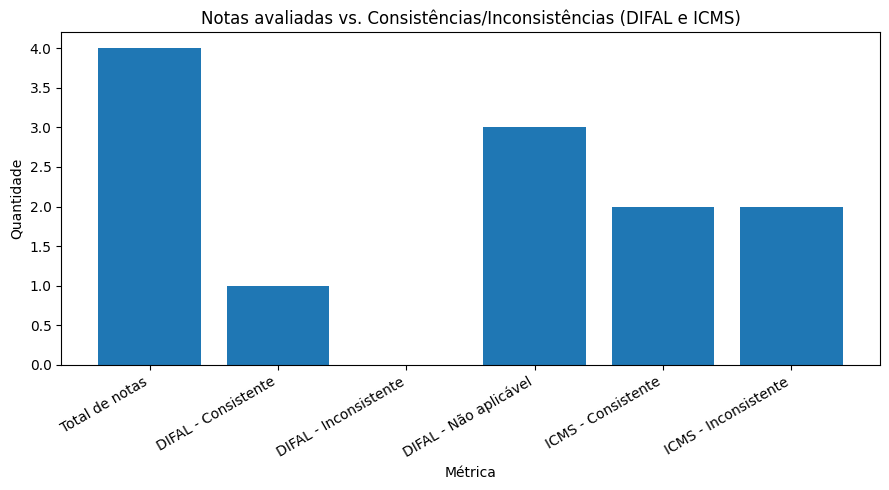

Gráfico salvo em: /content/nfe_saida/resumo_difal_icms.png

>>> AGENTE 4 — Movendo arquivos
Arquivos movidos. Verifique as subpastas em: /content/nfe_saida


In [6]:
# =========================
# EXECUTOR (PIPELINE COMPLETO)
# =========================
def executar_pipeline():
    print(">>> AGENTE 1 — Validação de XMLs")
    st_list, validos = agente1_validar_xmls(BASE_DIR)
    df_status = pd.DataFrame([asdict(s) for s in st_list])
    display(df_status)

    if not validos:
        print("Nenhum XML válido para processar.")
        return

    print("\n>>> AGENTE 2 — Avaliação ICMS/DIFAL via GPT-4.1-mini")
    df_res = agente2_executar(validos)
    display(df_res)

    print("\n>>> AGENTE 3 — Gráfico Resumo")
    grafico_png = os.path.join(OUTPUT_DIR, "resumo_difal_icms.png")
    agente3_grafico(df_res, save_path=grafico_png)
    print(f"Gráfico salvo em: {grafico_png}")

    if MOVE_FILES:
        print("\n>>> AGENTE 4 — Movendo arquivos")
        agente4_mover(df_res, BASE_DIR, OUTPUT_DIR)
        print("Arquivos movidos. Verifique as subpastas em:", OUTPUT_DIR)

# =========================
# RODAR
# =========================
executar_pipeline()